## Modeling for predicting 72h ED revisit at ED discharge

Flow:
1. Task-specific filter
2. Variable selection
3. Modeling script
4. Performance output


### Load train and test

In [1]:
import pandas as pd
import os
from helpers import PlotROCCurve
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import time

#path = 'C:/Users/XFE/Documents/mimic4ed-benchmark/data_processed/'
#path = '/home/jun/data/MIMIC/mimiciv/1.0/processed'
path = '/Users/siqili/Desktop/National University of Singapore/Liu Nan - WP_MIMIC_Benchmark'
output_path = '/Users/siqili/Desktop/National University of Singapore/Liu Nan - WP_MIMIC_Benchmark/Figure3/'
df_train = pd.read_csv((os.path.join(path, 'train.csv')))
df_test = pd.read_csv((os.path.join(path, 'test.csv')))
confidence_interval = 0.95


In [2]:
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 100) 
df_train.head()

index  subject_id     hadm_id   stay_id               intime  \
0  215414    18566742  27103162.0  38538786  2135-07-16 16:08:00   
1  205452    16853729         NaN  30043998  2178-01-25 05:09:00   
2  200705    16026698         NaN  39475313  2128-10-19 20:01:00   
3   87038    15398519  25237915.0  35495155  2147-06-15 09:50:00   
4  373626    16787687  23674090.0  31087259  2181-03-20 10:38:00   

               outtime  anchor_age gender  anchor_year  dod  \
0  2135-07-17 01:49:00          58      F         2132  NaN   
1  2178-01-25 07:05:00          91      F         2169  NaN   
2  2128-10-19 20:16:00          23      M         2128  NaN   
3  2147-06-15 15:55:00          57      M         2136  NaN   
4  2181-03-21 12:55:00          87      F         2176  NaN   

             admittime            dischtime deathtime               ethnicity  \
0  2135-07-17 00:20:00  2135-07-18 18:20:00       NaN         HISPANIC/LATINO   
1                  NaN                  NaN       NaN                   OTHER   
2                  NaN                  NaN       NaN                     NaN   
3  2147-06-15 14:00:00  2147-06-16 16:45:00       NaN  BLACK/AFRICAN AMERICAN   
4  2181-03-20 22:01:00  2181-03-21 12:55:00       NaN  BLACK/AFRICAN AMERICAN   

             edregtime            edouttime insurance  in_year  age  \
0  2135-07-16 16:08:00  2135-07-17 01:49:00     Other     2135   61   
1                  NaN                  NaN       NaN     2178  100   
2                  NaN                  NaN       NaN     2128   23   
3  2147-06-15 09:50:00  2147-06-15 15:55:00  Medicare     2147   68   
4  2181-03-20 10:38:00  2181-03-21 12:55:00  Medicare     2181   92   

   outcome_inhospital_mortality  ed_death  before_ed_mortality  \
0                         False     False                False   
1                         False     False                False   
2                         False     False                False   
3                         False     False                False   
4                         False     False                False   

            ed_los intime_icu time_to_icu_transfer  outcome_icu_transfer_12h  \
0  0 days 09:41:00        NaN                  NaN                     False   
1  0 days 01:56:00        NaN                  NaN                     False   
2  0 days 00:15:00        NaN                  NaN                     False   
3  0 days 06:05:00        NaN                  NaN                     False   
4  1 days 02:17:00        NaN                  NaN                     False   

   outcome_hospitalization  outcome_critical  n_ed_30d  n_ed_90d  n_ed_365d  \
0                     True             False         0         0          0   
1                    False             False         0         1          7   
2                    False             False         0         0          1   
3                     True             False         0         2          5   
4                     True             False         0         0          2   

    next_ed_visit_time next_ed_visit_time_diff  outcome_ed_revisit_3d  \
0  2136-07-30 17:08:00       379 days 15:19:00                  False   
1  2178-03-11 09:43:00        45 days 02:38:00                  False   
2  2129-01-05 21:12:00        78 days 00:56:00                  False   
3  2147-07-01 10:46:00        15 days 18:51:00                  False   
4  2181-04-06 09:43:00        15 days 20:48:00                  False   

   n_hosp_30d  n_hosp_90d  n_hosp_365d  n_icu_30d  n_icu_90d  n_icu_365d  \
0           0           0            0          0          0           0   
1           0           0            5          0          0           0   
2           0           0            0          0          0           0   
3           0           2            5          0          0           1   
4           0           0            2          0          0           0   

   ed_los_hours  time_to_icu_transfer_hours  next_ed_

In [3]:
#revise time range + function name

### 1. task-specific filter: exclude ED death cases for train and test

In [4]:
df_train = df_train[(df_train['before_ed_mortality'] == False) & (df_train['outcome_hospitalization'] == False) & (df_train['ed_death'] == False)]
df_test = df_test[(df_test['before_ed_mortality'] == False) & (df_test['outcome_hospitalization'] == False) & (df_test['ed_death'] == False)]

### 2. Variable Selection

In [5]:
variable = ["age", "gender", 
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache", 
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope",
            "chiefcom_dizziness",
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", "cci_Pulmonary", 
            "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", "cci_DM2", 
            "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", "cci_Cancer2", 
            "cci_HIV",
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2",  
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss", 
            "eci_Anemia", "eci_Alcohol", "eci_Drugs", "eci_Psychoses", "eci_Depression",
            
            "ed_temperature_last", "ed_heartrate_last", "ed_resprate_last", 
            "ed_o2sat_last", "ed_sbp_last", "ed_dbp_last", "ed_los", "n_med", "n_medrecon"]

outcome = "outcome_ed_revisit_3d"

In [6]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [7]:
X_train.dtypes.to_frame().T

age  gender n_ed_30d n_ed_90d n_ed_365d n_hosp_30d n_hosp_90d  \
0  int64  object    int64    int64     int64      int64      int64   

  n_hosp_365d n_icu_30d n_icu_90d n_icu_365d triage_pain triage_acuity  \
0       int64     int64     int64      int64     float64       float64   

  chiefcom_chest_pain chiefcom_abdominal_pain chiefcom_headache  \
0                bool                    bool              bool   

  chiefcom_shortness_of_breath chiefcom_back_pain chiefcom_cough  \
0                         bool               bool           bool   

  chiefcom_nausea_vomiting chiefcom_fever_chills chiefcom_syncope  \
0                     bool                  bool             bool   

  chiefcom_dizziness cci_MI cci_CHF cci_PVD cci_Stroke cci_Dementia  \
0               bool  int64   int64   int64      int64        int64   

  cci_Pulmonary cci_Rheumatic cci_PUD cci_Liver1 cci_DM1 cci_DM2  \
0         int64         int64   int64      int64   int64   int64   

  cci_Paralysis cci_Renal cci_Cancer1 cci_Liver2 cci_Cancer2 cci_HIV  \
0         int64     int64       int64      int64       int64   int64   

  eci_Arrhythmia eci_Valvular eci_PHTN eci_HTN1 eci_HTN2 eci_NeuroOther  \
0          int64        int64    int64    int64    int64          int64   

  eci_Hypothyroid eci_Lymphoma eci_Coagulopathy eci_Obesity eci_WeightLoss  \
0           int64        int64            int64       int64          int64   

  eci_FluidsLytes eci_BloodLoss eci_Anemia eci_Alcohol eci_Drugs  \
0           int64         int64      int64       int64     int64   

  eci_Psychoses eci_Depression ed_temperature_last ed_heartrate_last  \
0         int64          int64             float64           float64   

  ed_resprate_last ed_o2sat_last ed_sbp_last ed_dbp_last  ed_los    n_med  \
0          float64       float64     float64     float64  object  float64   

  n_medrecon  
0    float64

In [8]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [9]:
X_train['ed_los'] = pd.to_timedelta(X_train['ed_los']).dt.seconds / 60
X_test['ed_los'] = pd.to_timedelta(X_test['ed_los']).dt.seconds / 60

In [10]:
print('class ratio')
print('positive : negative =', y_train.sum()/(~y_train).sum(), ': 1')

class ratio
positive : negative = 0.047332185886402756 : 1


### 3.  Modeling script

In [11]:
# Containers for all results
result_list = []

Logistic Regression:


/Library/Python/3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training time: 3.985523223876953 seconds
AUC: 0.6782527320551448
AUPRC: 0.16653445799576483
Sensitivity: 0.5683972911963883
Specificity: 0.686449391988555
Score thresold: 0.041905087030353776
2.5 97.5


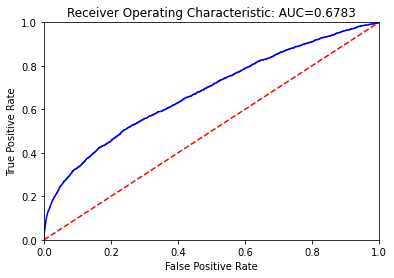

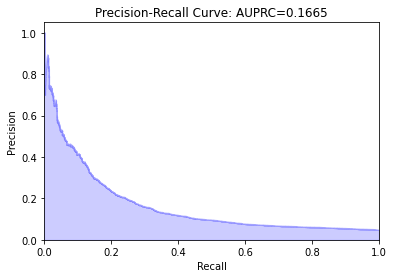

In [12]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression()
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)



MLP:
Training time: 89.12914800643921 seconds
AUC: 0.691825219113406
AUPRC: 0.16461010709405238
Sensitivity: 0.6
Specificity: 0.6725232474964234
Score thresold: 0.04268877582423316
2.5 97.5


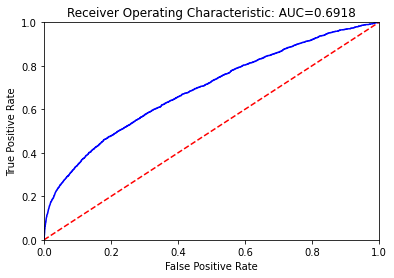

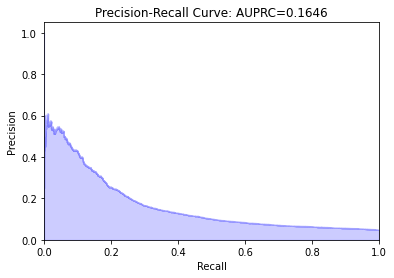

In [13]:
print("MLP:")
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
start = time.time()
mlp.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = mlp.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test)

results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)


RandomForest:
Training time: 33.78341197967529 seconds
AUC: 0.6631862381199198
AUPRC: 0.15765936602689057
Sensitivity: 0.6099322799097066
Specificity: 0.6254247138769671
Score thresold: 0.05
2.5 97.5


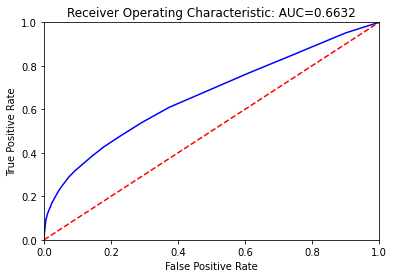

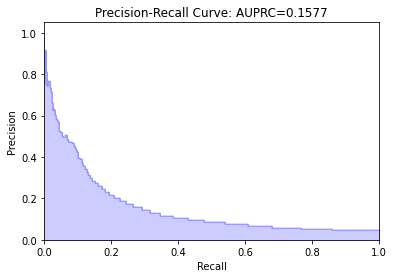

[0.08403939 0.01474092 0.02169352 0.02366261 0.03412357 0.00863242
 0.01225724 0.02080181 0.00101248 0.00211092 0.00406886 0.04470954
 0.02287156 0.00530366 0.00884599 0.00565512 0.00027494 0.00568531
 0.00226255 0.00410229 0.00316187 0.00200815 0.00320515 0.00280906
 0.00291194 0.00265787 0.00287527 0.00140704 0.00591028 0.00192561
 0.00175258 0.00415865 0.00522855 0.00280141 0.00140834 0.00283687
 0.00316631 0.00152738 0.00174091 0.00154968 0.00518885 0.00233839
 0.00236313 0.00283104 0.00677566 0.00443367 0.0036506  0.00108164
 0.00356796 0.00481109 0.00306889 0.00529426 0.00137929 0.0037982
 0.0057425  0.0047718  0.00342011 0.00607505 0.06649376 0.07603955
 0.0374533  0.03988052 0.0784352  0.07570622 0.08411766 0.03892633
 0.0504577 ]


In [14]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier()
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

GradientBoosting:
Training time: 37.42830228805542 seconds
AUC: 0.6956210369457174
AUPRC: 0.17322531175208128
Sensitivity: 0.5873589164785553
Specificity: 0.6903388769670958
Score thresold: 0.04020764428743692
2.5 97.5


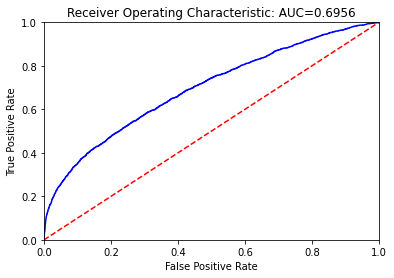

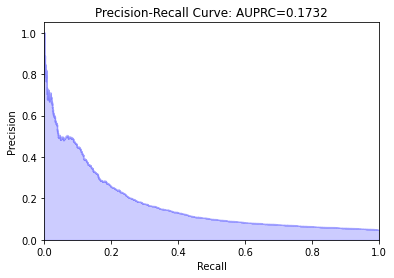

In [15]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [16]:
# Temporal skip
'''
print("Support Vector Machine:")
from sklearn.svm import SVC
svc=SVC()
start = time.time()
svc.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = svc.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)

results = ["SVM"]
results.extend(result)
results.append(runtime)
result_list.append(results)
'''

'\nprint("Support Vector Machine:")\nfrom sklearn.svm import SVC\nsvc=SVC()\nstart = time.time()\nsvc.fit(X_train,y_train)\nruntime = time.time()-start\nprint(\'Training time:\', runtime, \'seconds\')\nprobs = svc.predict_proba(X_test)\nresult = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)\n\nresults = ["SVM"]\nresults.extend(result)\nresults.append(runtime)\nresult_list.append(results)\n'

### 4. Performance output

In [17]:
#result_df = pd.read_csv(os.path.join(path, 'result_72h_ed_revivist_disposition.csv'))
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_72h_ed_revivist_disposition.csv'), index=False)
result_df

Model     auroc        ap  sensitivity  specificity  threshold  lower_auroc  \
0    LR  0.678253  0.166534     0.568397     0.686449   0.041905     0.665474   
1   MLP  0.691825  0.164610     0.600000     0.672523   0.042689     0.680440   
2    RF  0.663186  0.157659     0.609932     0.625425   0.050000     0.651779   
3    GB  0.695621  0.173225     0.587359     0.690339   0.040208     0.684991   

   upper_auroc  std_auroc  lower_ap  upper_ap    std_ap  lower_sensitivity  \
0     0.689144   0.006277  0.149285  0.182099  0.007705           0.544747   
1     0.703732   0.006130  0.148387  0.180092  0.008022           0.580009   
2     0.676460   0.006531  0.142812  0.174786  0.007800           0.537752   
3     0.708107   0.006090  0.155838  0.188895  0.008042           0.579009   

   upper_sensitivity  std_sensitivity  lower_specificity  upper_specificity  \
0           0.602108         0.016179           0.655721           0.718638   
1           0.637321         0.015539           0.634772           0.697575   
2           0.630727         0.027286           0.621697           0.710631   
3           0.660388         0.023561           0.618487           0.698776   

   std_specificity    runtime  
0         0.019163   3.985523  
1         0.018582  89.129148  
2         0.033065  33.783412  
3         0.027229  37.428302

In [18]:
result_df

Model     auroc        ap  sensitivity  specificity  threshold  lower_auroc  \
0    LR  0.678253  0.166534     0.568397     0.686449   0.041905     0.665474   
1   MLP  0.691825  0.164610     0.600000     0.672523   0.042689     0.680440   
2    RF  0.663186  0.157659     0.609932     0.625425   0.050000     0.651779   
3    GB  0.695621  0.173225     0.587359     0.690339   0.040208     0.684991   

   upper_auroc  std_auroc  lower_ap  upper_ap    std_ap  lower_sensitivity  \
0     0.689144   0.006277  0.149285  0.182099  0.007705           0.544747   
1     0.703732   0.006130  0.148387  0.180092  0.008022           0.580009   
2     0.676460   0.006531  0.142812  0.174786  0.007800           0.537752   
3     0.708107   0.006090  0.155838  0.188895  0.008042           0.579009   

   upper_sensitivity  std_sensitivity  lower_specificity  upper_specificity  \
0           0.602108         0.016179           0.655721           0.718638   
1           0.637321         0.015539           0.634772           0.697575   
2           0.630727         0.027286           0.621697           0.710631   
3           0.660388         0.023561           0.618487           0.698776   

   std_specificity    runtime  
0         0.019163   3.985523  
1         0.018582  89.129148  
2         0.033065  33.783412  
3         0.027229  37.428302

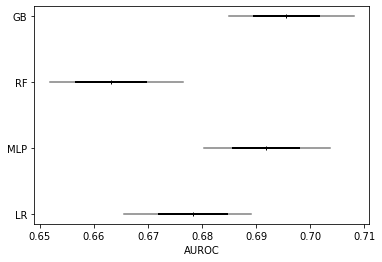

In [19]:
from helpers import plot_confidence_interval
#plot_confidence_interval(result_df, metric='auroc', ci=confidence_interval, name = "AUROC" )
plot_confidence_interval(result_df, metric='auroc', ci=confidence_interval, name = "AUROC", 
                         my_file = 'AUROC_72h.eps', my_path = output_path) 

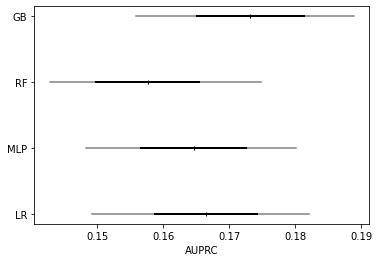

In [20]:
plot_confidence_interval(result_df, metric='ap', ci=confidence_interval, name = "AUPRC", 
                         my_file = 'AUPRC_72h.eps', my_path = output_path)

In [21]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv(os.path.join(path, 'importances_72h_ed_revisit_disposition.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)

Variable  Importance
64                        ed_los    0.084118
0                            age    0.084039
62                   ed_sbp_last    0.078435
59             ed_heartrate_last    0.076040
63                   ed_dbp_last    0.075706
58           ed_temperature_last    0.066494
66                    n_medrecon    0.050458
11                   triage_pain    0.044710
61                 ed_o2sat_last    0.039881
65                         n_med    0.038926
60              ed_resprate_last    0.037453
4                      n_ed_365d    0.034124
3                       n_ed_90d    0.023663
12                 triage_acuity    0.022872
2                       n_ed_30d    0.021694
7                    n_hosp_365d    0.020802
1                         gender    0.014741
6                     n_hosp_90d    0.012257
14       chiefcom_abdominal_pain    0.008846
5                     n_hosp_30d    0.008632
44                      eci_HTN2    0.006776
57                eci_Depression    0.006075
28                 cci_Pulmonary    0.005910
54                   eci_Alcohol    0.005743
17            chiefcom_back_pain    0.005685
15             chiefcom_headache    0.005655
13           chiefcom_chest_pain    0.005304
51               eci_FluidsLytes    0.005294
32                       cci_DM1    0.005229
40                eci_Arrhythmia    0.005189
49                   eci_Obesity    0.004811
55                     eci_Drugs    0.004772
45                eci_NeuroOther    0.004434
31                    cci_Liver1    0.004159
19      chiefcom_nausea_vomiting    0.004102
10                    n_icu_365d    0.004069
53                    eci_Anemia    0.003798
46               eci_Hypothyroid    0.003651
48              eci_Coagulopathy    0.003568
56                 eci_Psychoses    0.003420
22            chiefcom_dizziness    0.003205
36                   cci_Cancer1    0.003166
20         chiefcom_fever_chills    0.003162
50                eci_WeightLoss    0.003069
24                       cci_CHF    0.002912
26                    cci_Stroke    0.002875
35                     cci_Renal    0.002837
43                      eci_HTN1    0.002831
23                        cci_MI    0.002809
33                       cci_DM2    0.002801
25                       cci_PVD    0.002658
42                      eci_PHTN    0.002363
41                  eci_Valvular    0.002338
18                chiefcom_cough    0.002263
9                      n_icu_90d    0.002111
21              chiefcom_syncope    0.002008
29                 cci_Rheumatic    0.001926
30                       cci_PUD    0.001753
38                   cci_Cancer2    0.001741
39                       cci_HIV    0.001550
37                    cci_Liver2    0.001527
34                 cci_Paralysis    0.001408
27                  cci_Dementia    0.001407
52                 eci_BloodLoss    0.001379
47                  eci_Lymphoma    0.001082
8                      n_icu_30d    0.001012
16  chiefcom_shortness_of_breath    0.000275